In [50]:
import pandas as pd
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from transformers import BertTokenizer, TFBertForSequenceClassification, TFAutoModelForSequenceClassification
from transformers import create_optimizer
from sklearn.preprocessing import LabelEncoder

# Loading the Dataset

In [51]:
# Load the datasets
train_df = pd.read_csv('/kaggle/input/twitter-financial-news-sentiment-dataset/sent_train.csv')
valid_df = pd.read_csv('/kaggle/input/twitter-financial-news-sentiment-dataset/sent_valid.csv')

# Encode labels using LabelEncoder
label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['label'])
valid_df['label'] = label_encoder.transform(valid_df['label'])

# Tokenization

In [52]:
# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text data for training and validation
train_encodings = tokenizer(
    train_df['text'].tolist(),
    truncation=True,
    padding=True,
    max_length=128
)

valid_encodings = tokenizer(
    valid_df['text'].tolist(),
    truncation=True,
    padding=True,
    max_length=128
)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# Creating tensorflow data

In [53]:
# Create TensorFlow datasets for training and display the shape
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_df['label'].values
)).shuffle(10000).batch(16)

for batch in train_dataset.take(1):
    print("Train Input shape:", batch[0]['input_ids'].shape)
    print("Train Label shape:", batch[1].shape)
    

# Create TensorFlow datasets for validation and display the shape
valid_dataset = tf.data.Dataset.from_tensor_slices((
    dict(valid_encodings),
    valid_df['label'].values
)).batch(16)

for batch in valid_dataset.take(1):
    print("Validation Input shape:", batch[0]['input_ids'].shape)
    print("Validation Label shape:", batch[1].shape)

# Creating & training the model

In [55]:
# Load the BERT model for sequence classification
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Define optimizer and learning rate schedule
steps_per_epoch = len(train_df) // 16
num_train_steps = steps_per_epoch * 5
optimizer, lr_schedule = create_optimizer(
    init_lr = 3e-5,
    num_train_steps = num_train_steps,
    num_warmup_steps = 0
)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 3,
    restore_best_weights = True
)

history = model.fit(
    train_dataset,
    validation_data = valid_dataset,
    epochs = 5,
    callbacks = [early_stopping]
)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
597/597 [==============================] - 188s 213ms/step - loss: 0.9503 - accuracy: 0.6460 - val_loss: 0.6462 - val_accuracy: 0.8116
Epoch 2/5
597/597 [==============================] - 115s 193ms/step - loss: 0.7284 - accuracy: 0.7841 - val_loss: 0.5823 - val_accuracy: 0.8384
Epoch 3/5
597/597 [==============================] - 115s 193ms/step - loss: 0.5447 - accuracy: 0.8537 - val_loss: 0.5587 - val_accuracy: 0.8660
Epoch 4/5
597/597 [==============================] - 115s 193ms/step - loss: 0.4357 - accuracy: 0.8915 - val_loss: 0.5399 - val_accuracy: 0.8777
Epoch 5/5
597/597 [==============================] - 116s 194ms/step - loss: 0.3588 - accuracy: 0.9119 - val_loss: 0.6963 - val_accuracy: 0.8752


# Confusion Matrix

150/150 [==============================] - 10s 66ms/step


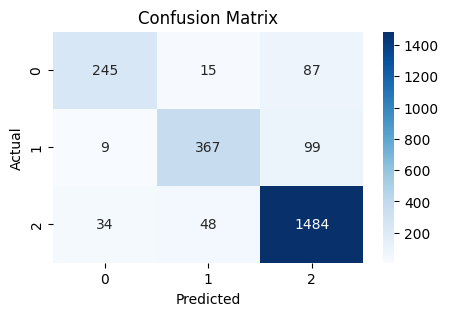

In [69]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions from the model
predictions = model.predict(valid_dataset)
y_pred = np.argmax(predictions.logits, axis=1)
yTest = valid_df['label'].values

# Get the true labels from the validation dataset
y_true = valid_df['label'].values

# Generate the confusion matrix
conf_matrix = confusion_matrix(yTest, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# ROC curve

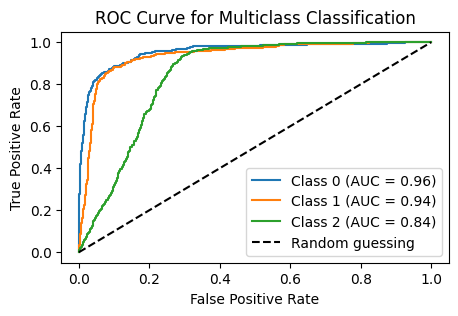

In [67]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the output labels (one-vs-rest for multiclass ROC/AUC)
yTest_bin = label_binarize(yTest, classes=[0, 1, 2])

# Get the predicted probabilities (logits)
y_pred_prob = predictions.logits

# Plot ROC curve for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):  # Assuming 3 classes: 0, 1, 2
    fpr[i], tpr[i], _ = roc_curve(yTest_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(5, 3))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--', label='Random guessing')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Classification Report

In [78]:
import numpy as np
from sklearn.metrics import classification_report

# Get predictions from the model
predictions = model.predict(valid_dataset)
y_pred = np.argmax(predictions.logits, axis=1)

# Ensure that y_true is a numpy array
y_true = np.array(valid_df['label'].values)

# Convert y_pred to a numpy array
y_pred = np.array(y_pred)

# Generate the classification report without target_names to test
report = classification_report(y_true, y_pred)

# Print the classification report
print(report)

150/150 [==============================] - 10s 66ms/step
              precision    recall  f1-score   support

           0       0.85      0.71      0.77       347
           1       0.85      0.77      0.81       475
           2       0.89      0.95      0.92      1566

    accuracy                           0.88      2388
   macro avg       0.86      0.81      0.83      2388
weighted avg       0.88      0.88      0.87      2388

